# [ EXPLORATION ] 3. 어제 오른 내 주식, 과연 내일은?

✅ARIMA 시계열 분석법을 배우고, 직접 주식 시세를 예측해본다.

---
### - 📖목차
* ✔️3-9. 프로젝트 : 주식 예측에 도전해 보자
* ✔️STEP 7. 관심 종목을 골라 위 'STEP 1~6' 의 과정을 반복해 보기(거시경제변수로 주식 투자에 적기인지 판단하기)
    1. 이론 정립
    2. 거시경제변수 도출하기(금리, 환율, 물가, 원자재)
    3. 연관성을 위한 주가 예측(미국 주가, 국내 주가)
    4. 프로젝트 결론
* ✔️회고 및 결론
* ✔️Reference(참고자료)

<br>



## ✔️3-9. 프로젝트 : 주식 예측에 도전해 보자
---



#### STEP 1 : 시계열 데이터 준비

In [1]:
# 모듈
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
# statsmodels 업데이트(이걸 안하면 코랩에서는 ARIMA 모델이 안돌아갑니다.....)
!pip install statsmodels==0.12.1

     |████████████████████████████████| 9.5 MB 4.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
# 파일 로드
from google.colab import files
files.upload()

In [4]:
# 통계관련 필요한 툴들 로드
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA #업뎃을 안할경우 코랩에서는 ARIMA 안돌아감에 유의

In [5]:
# 경고 무시
import warnings
warnings.filterwarnings('ignore') 

In [6]:
# 데이터 로드
dataset_filepath = '005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

df.head() # 종목티커 005930: 삼성전자의 데이터

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


* 삼성전자(티커 005930)의 데이터
* [시가(open), 고가(high), 저가(low), 종가(close), 조정 종가(adj close), 거래량(volume)] 순서로 배열되어 있음을 확인

In [7]:
ts.head() # 시계열 데이터로도 확인

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

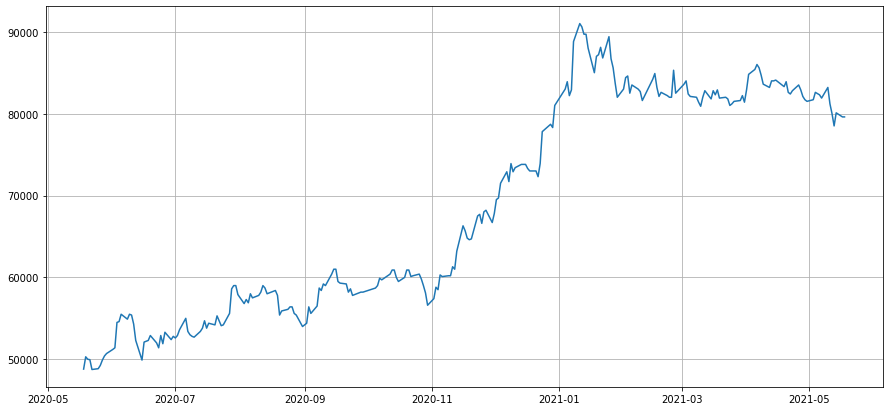

In [13]:
#그래프 크기를 위해 모듈 로드
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 7 #차트 크기를 15, 7로 지정

# 데이터 확인
plt.grid(True)
plt.plot(ts)

#### STEP 2 : 각종 전처리 수행

In [14]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

* 따로 결측치가 발견되지 않은 것을 확인했다. 만약 여기서 결측치가 나올 경우에는 지우기보다는 시계열 데이터이므로 보간하는 방법이 나을 것 같다....

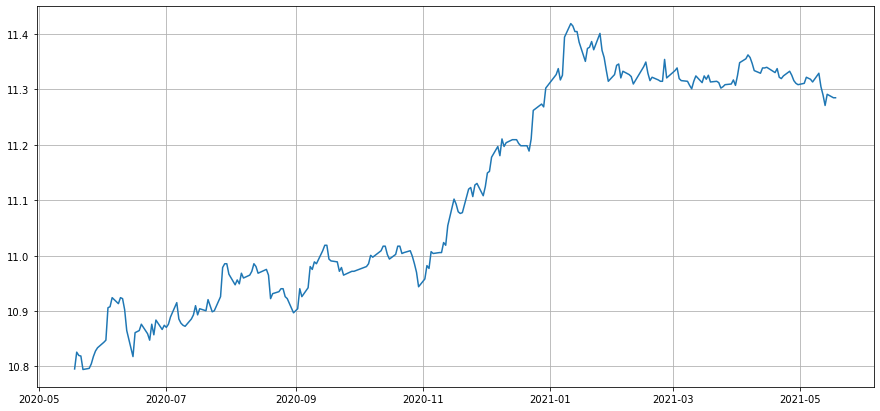

In [15]:
# 로그 변환
ts_log = np.log(ts)
plt.grid(True)
plt.plot(ts_log)

In [16]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

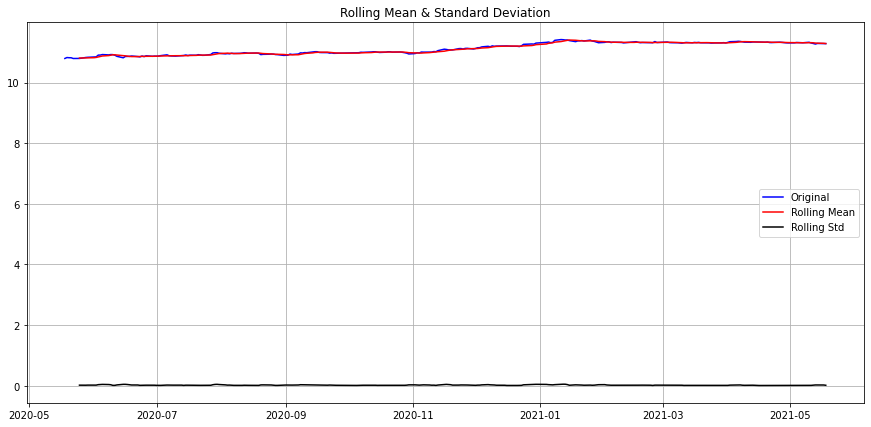

In [17]:
# 정성적 그래프 분석
plt.grid(True)
plot_rolling_statistics(ts_log, window=6) #타임 step은 6으로 설정

In [18]:
# 정량적 Augmented Dicky-Fuller Test
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

#### STEP 3 : 시계열 안정성 분석

In [19]:
# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


* 귀무가설로 미루어 볼때 여기서 p-value는 0.59 정도로 안정적이지 않음을 발견했다.
* 귀무가설을 기각할 수 없게 되었으므로 안정적인 시계열을 뽑아내기 위해서 시계열 분해를 적용할 것을 결정했다.

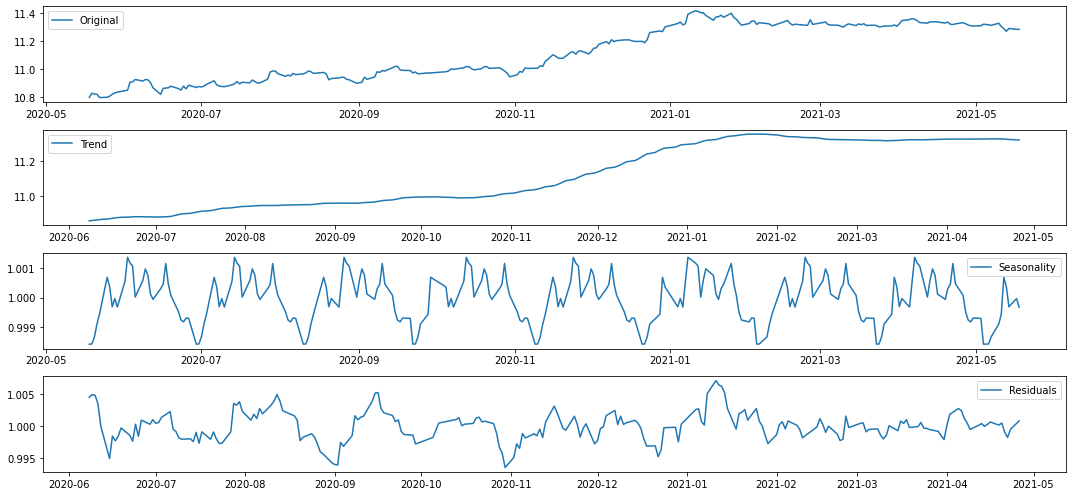

In [20]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [21]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


* 시계열 분해를 통해서 Original에서 Trend, Seasonality를 제거했다.
* 분해를 끝낸 Residuals의 경우 수치가 확연히 바뀌어 충분히 예측으로 쓸만한 안정적 시계열을 추출했다고 볼 수 있을 것 같다.

#### STEP 4 : 학습, 테스트 데이터셋 생성

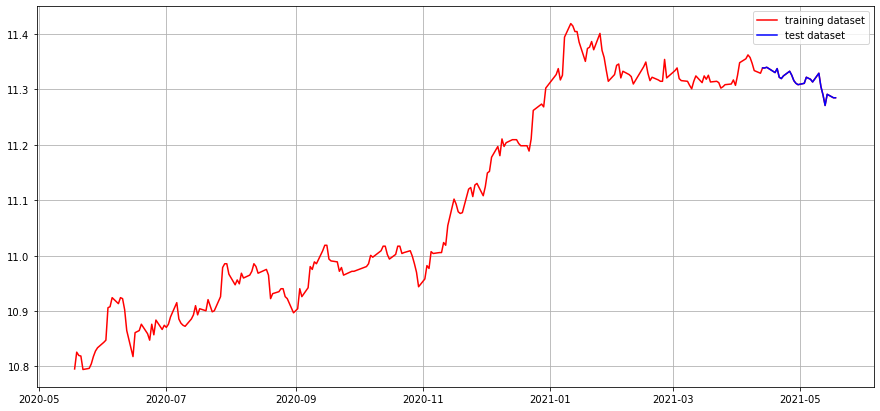

In [24]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.grid(True)
# train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(ts_log, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### STEP 5 : 적정 ARIMA 모수 찾기

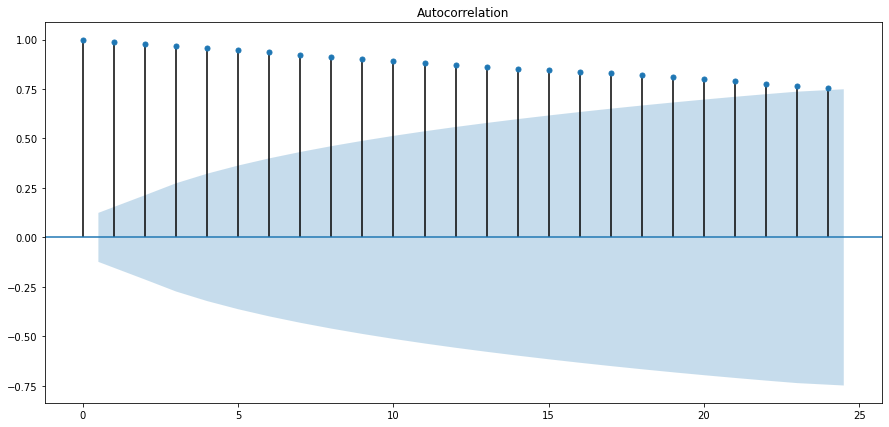

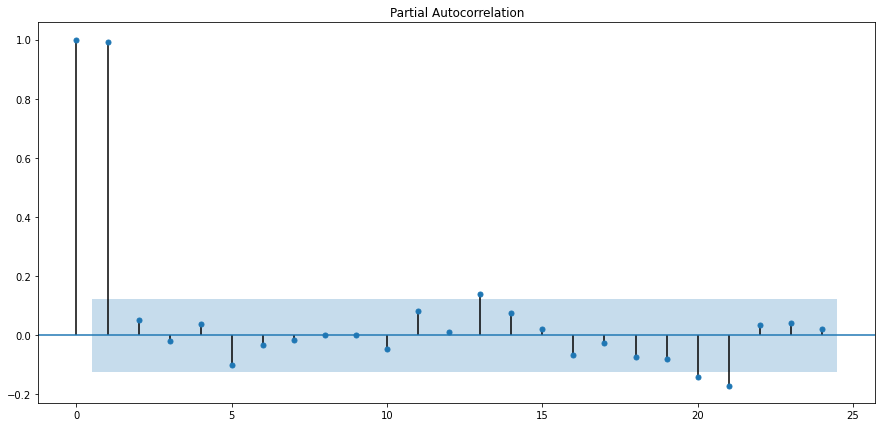

In [25]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

* ACF가 1에서 시작해서 점차 감소하고 있음을 확인했으므로, q의 값은 0이 적당한 것 같다고 추측했다.
* PACF같은 경우 두번째 구간부터 시작해서 0에 급속도로 가까워졌기 때문에 상관도를 고려할 필요가 없다는 결론을 이끌어낼 수 있었다.

= 따라서 ARIMA 모델의 모수는 이를 통해 미루어볼 때 (1, 1, 0) 또는 (1, 0, 0)으로 진행하기로 결정했다.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


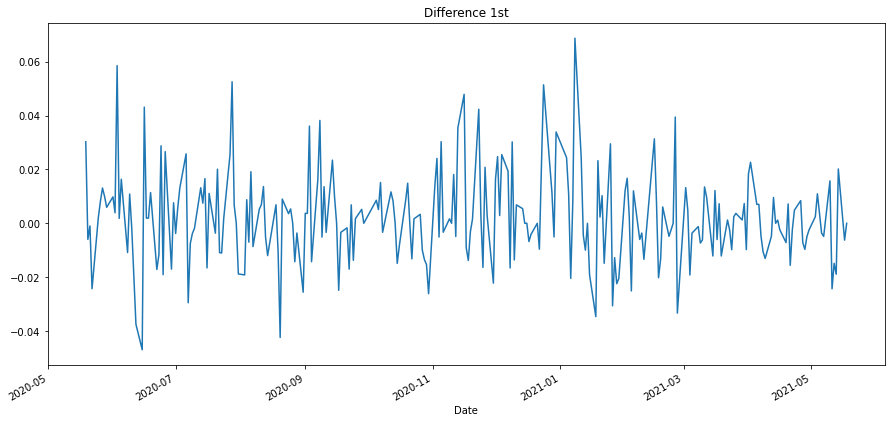

In [26]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

* 1차 차분을 진행한 뒤에는 p-value가 2.18 정도로 낮아진 것을 확인할 수 있었다.

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


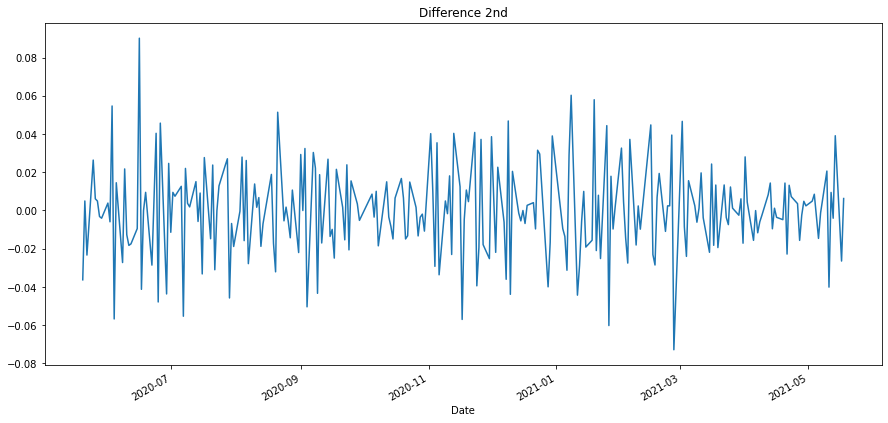

In [27]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

#### STEP 6 : ARIMA 모델 훈련과 테스트

In [28]:
#모듈 로드(사실 위에서 버전 확인때문에 이미 한번 로딩했었다..)
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

# Build and Train  Model
model = ARIMA(train_data, order=(1, 0, 0))  #p = 1, d = 0, q = 0
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  225
Model:                     ARMA(1, 0)   Log Likelihood                 583.467
Method:                       css-mle   S.D. of innovations              0.018
Date:                Sun, 01 May 2022   AIC                          -1160.933
Time:                        06:25:34   BIC                          -1150.685
Sample:                             0   HQIC                         -1156.797
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          11.0688      0.210     52.701      0.000      10.657      11.480
ar.L1.Close     0.9972      0.003    298.854      0.000       0.991       1.004
                                    Roots       

* 코랩에서는 ARIMA모델을 돌릴 경우에도 d값이 0이면 ARMA로 바뀌어 나오는 걸 확인했다. 수치값이 다를까 싶어 아이펠 주피터 노트북으로 돌려본 뒤, 결과치가 크게 다르지 않아서 계속 진행했다.

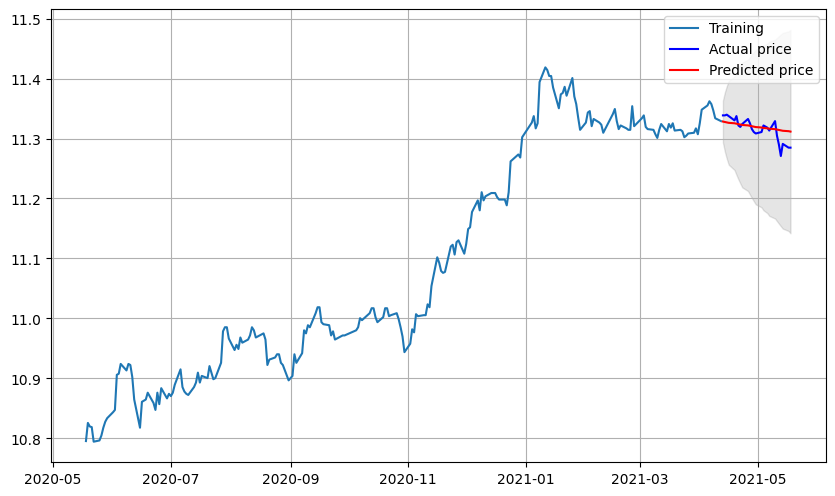

In [30]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# 그래프 구현
plt.figure(figsize=(10,6), dpi=100)
plt.grid(True)
plt.plot(train_data, label='Training')
plt.plot(test_data, c='b', label='Actual price')
plt.plot(fc_series, c='r',label='Predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

* 모수를 바꿔서 여러 경우를 돌려봤는데(0, 0, 0), (1, 0, 1), (1, 1, 1,)등... 1차 차분을 하지 않은 상태의 1, 0, 0의 값에서  실제 가격과 예측가격이 똑같이 하방으로 내려가는 흡사한 모습을 보여서 최종적으로 채택하게 되었다. 결국 이후의 삼성 주식은 떨어질 모양이었나보다.

In [32]:
#최종 오차 계산 결과
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('- MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('- MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('- RMSE: ', rmse)

mape0 = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('- MAPE: {:.2f}%'.format(mape0*100)) # 여기서 가장 중요하게 쓰인 손실함수 오차값

- MSE:  1533430.4832786121
- MAE:  957.802482046241
- RMSE:  1238.3176019416878
- MAPE: 1.18%


* 로그를 변환한 상태에서 다시 지수로 변환후, 오차를 계산하기 위해 np.exp()가 쓰였다. 이번 예측 모델에서 적당한 손실함수는 MAPE로, 오차값이 2퍼센트 아래이기 때문에 최적화가 되었다고 평가해도 좋을 것 같다.

<br>



## ✔️STEP 7. 관심 종목을 골라 위 'STEP 1~6' 의 과정을 반복해 보기
## (거시경제변수로 주식 투자에 적기인지 판단하기)
---



#### 1. 이론정립

![003](https://user-images.githubusercontent.com/100528803/166132438-e449482a-fd6a-4b9c-84ac-e3adb8b8f94e.png)

주식에 투자하기 위해서는 거시적인 경제 상황을 먼저 파악하는게 필수다. 따라서 여기서는 특정 주식 대신 거시경제변수를 대표할 수 있는 지수들의 티커를 추출해 시계열 데이터로 예측한 후, 현재 상황에서 주식 투자가 괜찮을지의 여부를 러프하게 살펴보기로 한다.

* [금리] 미국 10년 국채 금리(^TNX)
* [물가] Tiger 200 Industrials ETF(227550.KS)
* [환율] 원달러 환율(KRW=X)
* [원자재:유가] WTI

여기에 실제 주식과의 연관성을 위해서 미국 주가와 국내 주가 모두를 가져온다.

* [미국 주가] S&P 500(SPXL)
* [국내 주가] 코스피(^KS11)

<br>



### 2. 거시경제변수 도출하기
-----
#### 2-1. [금리] 미국 10년 국채 금리(^TNX)

In [33]:
# 데이터 로드 및 Time Series 생성하기
dataset_filepath = '^TNX.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-04-30,1.642,1.653,1.622,1.631,1.631,0.0
2021-05-02,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-03,1.651,1.651,1.578,1.607,1.607,0.0
2021-05-04,1.603,1.603,1.557,1.592,1.592,0.0
2021-05-05,1.607,1.626,1.582,1.584,1.584,0.0


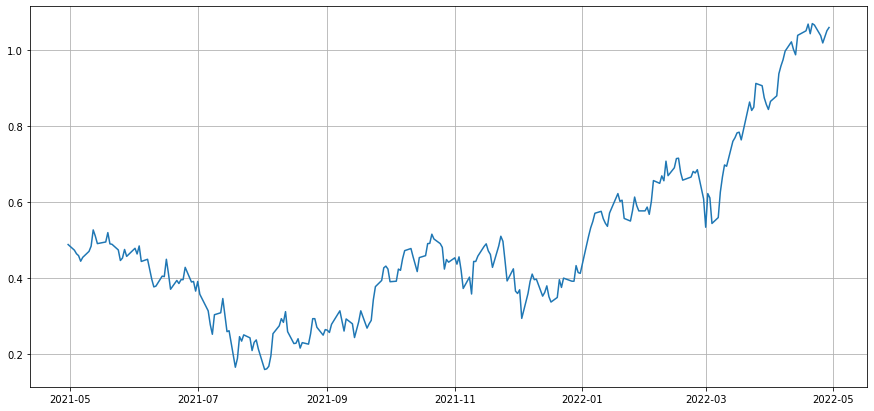

In [34]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # 결측치가 있는 부분만 Series로 출력

# 로그 변환
ts_log = np.log(ts)
plt.grid(True)
plt.plot(ts_log)

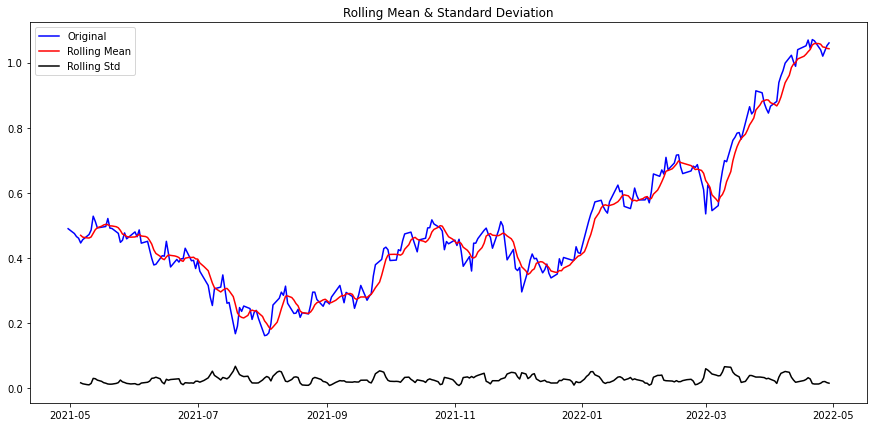

Results of Dickey-Fuller Test:
Test Statistic                   0.586501
p-value                          0.987278
#Lags Used                       0.000000
Number of Observations Used    305.000000
Critical Value (1%)             -3.451974
Critical Value (5%)             -2.871063
Critical Value (10%)            -2.571844
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.032253e+00
p-value                        6.142395e-10
#Lags Used                     3.000000e+00
Number of Observations Used    2.720000e+02
Critical Value (1%)           -3.454622e+00
Critical Value (5%)           -2.872225e+00
Critical Value (10%)          -2.572464e+00
dtype: float64


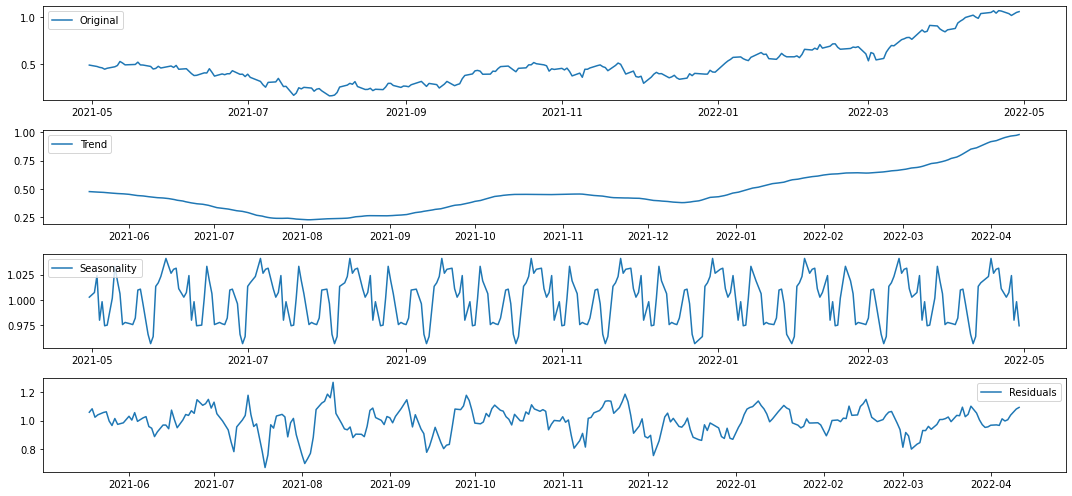

In [35]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=6) #타임 step은 6으로 설정

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

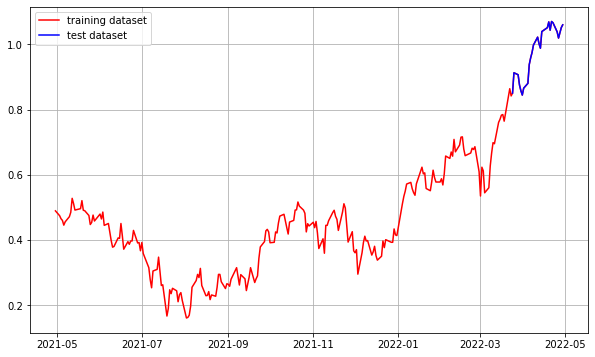

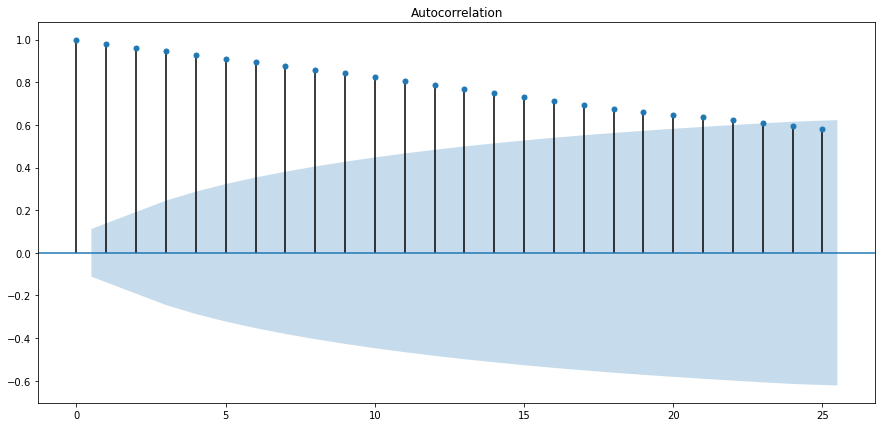

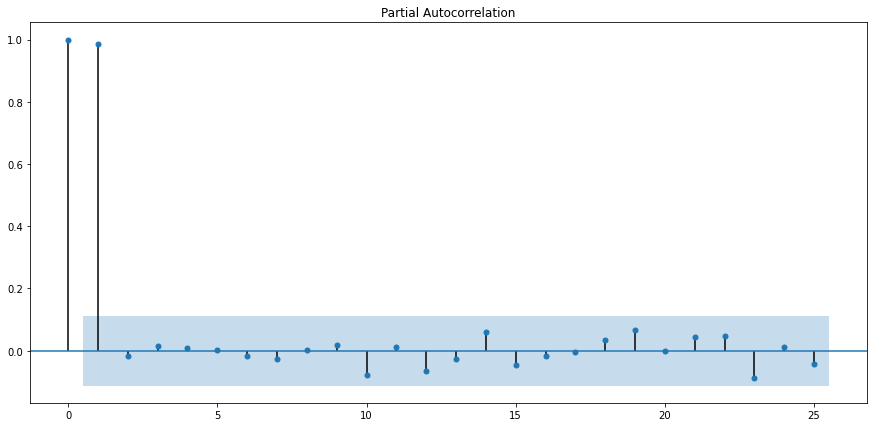

In [36]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)

# train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(ts_log, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.690314e+01
p-value                        1.024050e-29
#Lags Used                     0.000000e+00
Number of Observations Used    3.040000e+02
Critical Value (1%)           -3.452045e+00
Critical Value (5%)           -2.871095e+00
Critical Value (10%)          -2.571861e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.005737e+01
p-value                        1.361783e-17
#Lags Used                     1.000000e+01
Number of Observations Used    2.930000e+02
Critical Value (1%)           -3.452867e+00
Critical Value (5%)           -2.871455e+00
Critical Value (10%)          -2.572053e+00
dtype: float64


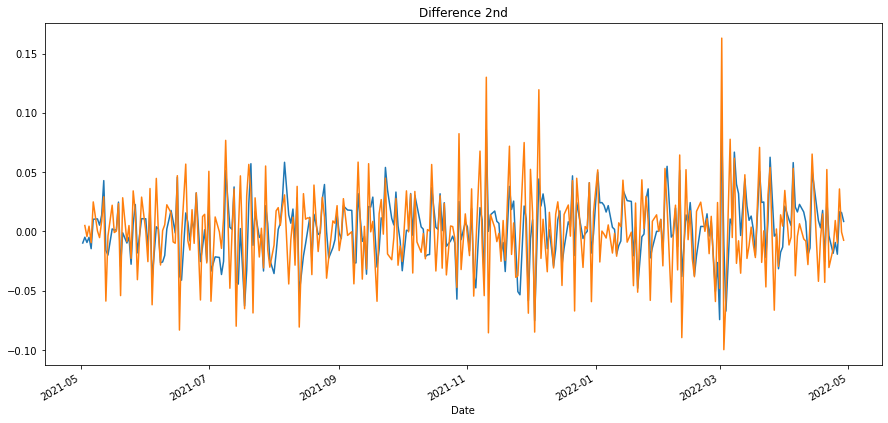

In [37]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  274
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 607.024
Method:                       css-mle   S.D. of innovations              0.026
Date:                Sun, 01 May 2022   AIC                          -1208.049
Time:                        06:27:02   BIC                          -1197.209
Sample:                             1   HQIC                         -1203.698
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0013      0.002      0.791      0.429      -0.002       0.004
ar.L1.D.Close     0.0186      0.060      0.308      0.758      -0.100       0.137
                                    Root

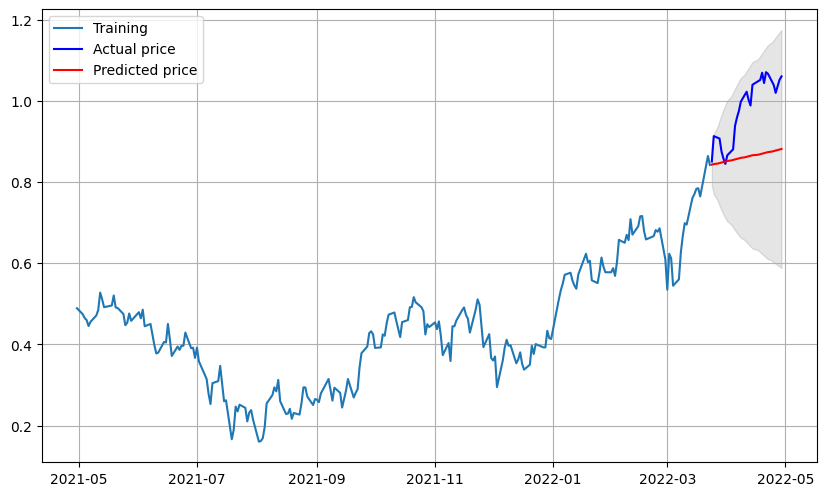

- MSE:  0.12043501827107461
- MAE:  0.29980458009373023
- RMSE:  0.34703748827911174
- MAPE: 10.80%


In [38]:
# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0)) 
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,6), dpi=100)
plt.grid(True)
plt.plot(train_data, label='Training')
plt.plot(test_data, c='b', label='Actual price')
plt.plot(fc_series, c='r',label='Predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

#최종 오차 계산 결과
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('- MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('- MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('- RMSE: ', rmse)

mape1 = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('- MAPE: {:.2f}%'.format(mape1*100)) # 여기서 가장 중요하게 쓰인 손실함수 오차값

* 미국 10년 국채의 경우 상승세를 가리키고 있으며, MAPE 값이 10.80이므로 15퍼센트 이하의 오차를 보여줬다.

#### 2-2. [물가] Tiger 200 Industrials ETF(227550.KS)

In [ ]:
# 데이터 로드 및 Time Series 생성하기
dataset_filepath = '227550.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-03,6900.0,6900.0,6645.0,6660.0,6660.0,5173.0
2021-05-04,6600.0,6645.0,6515.0,6630.0,6630.0,2263.0
2021-05-06,6630.0,7000.0,6630.0,7000.0,7000.0,17866.0
2021-05-07,7040.0,7190.0,7010.0,7140.0,7140.0,9848.0
2021-05-10,7200.0,7345.0,7095.0,7345.0,7345.0,23957.0


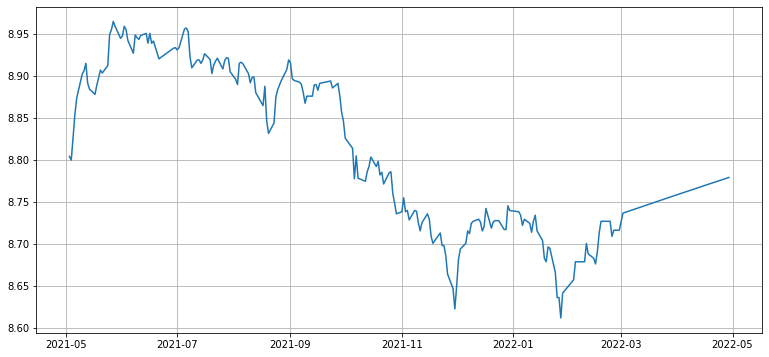

In [ ]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # 결측치가 있는 부분만 Series로 출력

# 로그 변환
ts_log = np.log(ts)
plt.grid(True)
plt.plot(ts_log)

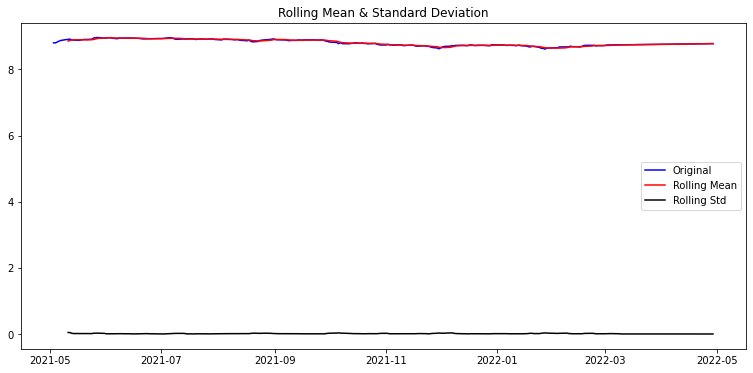

Results of Dickey-Fuller Test:
Test Statistic                  -1.054057
p-value                          0.733041
#Lags Used                       0.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -5.504833
p-value                          0.000002
#Lags Used                       1.000000
Number of Observations Used    213.000000
Critical Value (1%)             -3.461429
Critical Value (5%)             -2.875207
Critical Value (10%)            -2.574054
dtype: float64


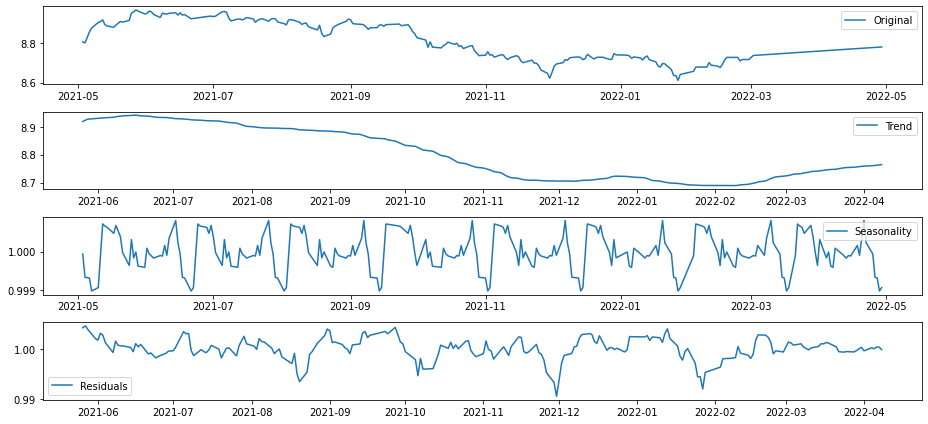

In [ ]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=6) #타임 step은 6으로 설정

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

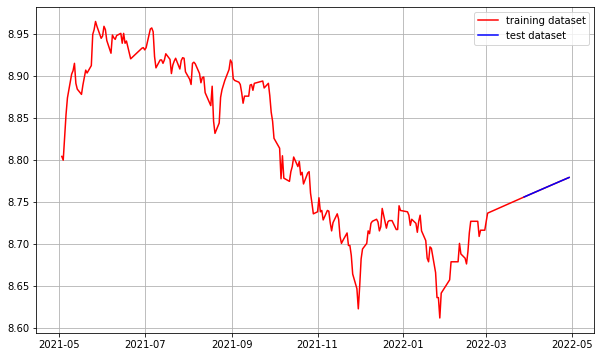

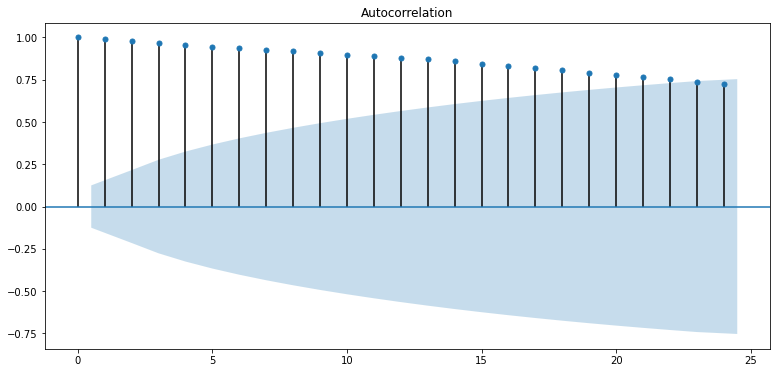

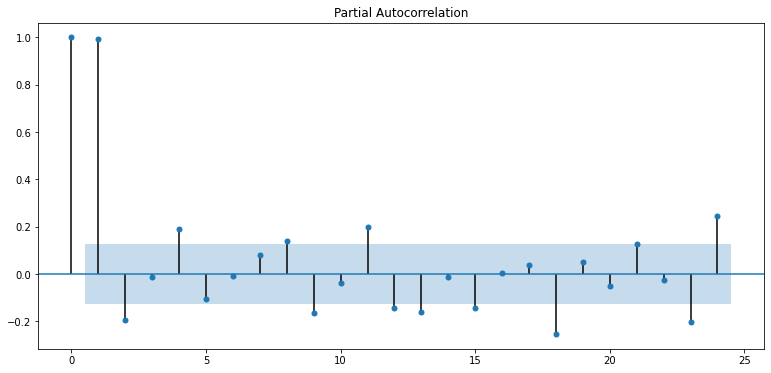

In [ ]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)

# train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(ts_log, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.392776e+01
p-value                        5.155782e-26
#Lags Used                     0.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.261024e+00
p-value                        1.681451e-10
#Lags Used                     1.500000e+01
Number of Observations Used    2.270000e+02
Critical Value (1%)           -3.459490e+00
Critical Value (5%)           -2.874358e+00
Critical Value (10%)          -2.573602e+00
dtype: float64


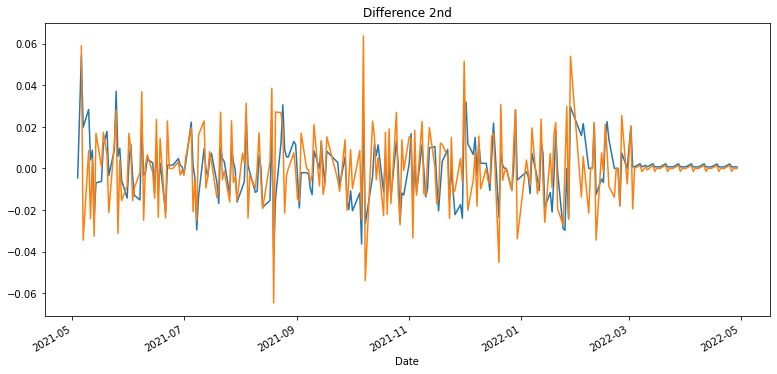

In [ ]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  275
Model:                     ARMA(1, 0)   Log Likelihood                 607.495
Method:                       css-mle   S.D. of innovations              0.026
Date:                Sun, 01 May 2022   AIC                          -1208.989
Time:                        06:27:30   BIC                          -1198.139
Sample:                             0   HQIC                         -1204.635
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5343      0.130      4.101      0.000       0.279       0.790
ar.L1.Close     0.9901      0.008    120.476      0.000       0.974       1.006
                                    Roots       

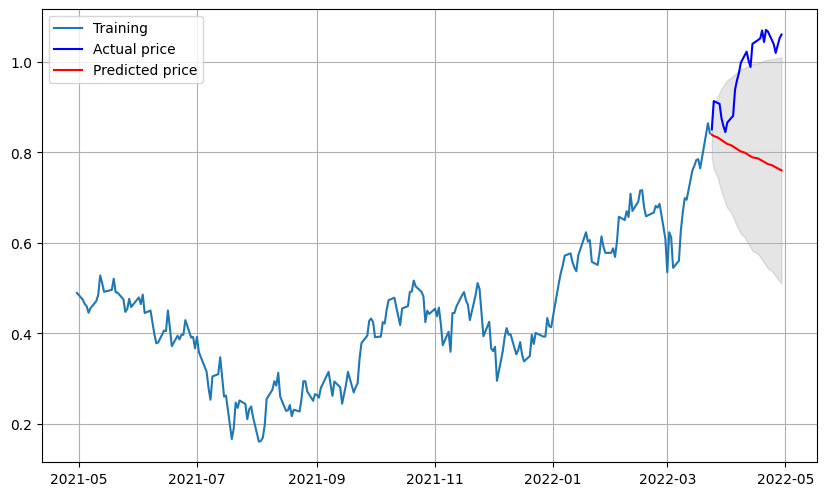

- MSE:  0.26091475514826135
- MAE:  0.4464529694499206
- RMSE:  0.5107981549969237
- MAPE: 16.11%


In [39]:
# Build and Train  Model
model = ARIMA(train_data, order=(1, 0, 0)) 
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# 그래프 구현
plt.figure(figsize=(10,6), dpi=100)
plt.grid(True)
plt.plot(train_data, label='Training')
plt.plot(test_data, c='b', label='Actual price')
plt.plot(fc_series, c='r',label='Predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

#최종 오차 계산 결과
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('- MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('- MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('- RMSE: ', rmse)

mape2 = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('- MAPE: {:.2f}%'.format(mape2*100)) # 여기서 가장 중요하게 쓰인 손실함수 오차값

* Tiger 200 Industrials ETF의 경우 상승세를 가리키고 있으며, MAPE 값이 0.74% 이므로 현재 기준 1퍼센트 안팎의 꽤 정확한 예측을 보여줬다.

#### 2-3. [환율] 원달러 환율(KRW=X)

In [40]:
# 데이터 로드 및 Time Series 생성하기
dataset_filepath = 'KRW=X.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-04-28,1112.150024,1114.310059,1109.609985,1112.150024,1112.150024,0
2021-04-29,1108.890015,1109.349976,1104.250000,1108.660034,1108.660034,0
2021-04-30,1106.579956,1116.790039,1106.180054,1106.630005,1106.630005,0
2021-05-03,1116.609985,1123.890015,1115.069946,1116.760010,1116.760010,0
2021-05-04,1120.400024,1127.859985,1118.640015,1120.400024,1120.400024,0


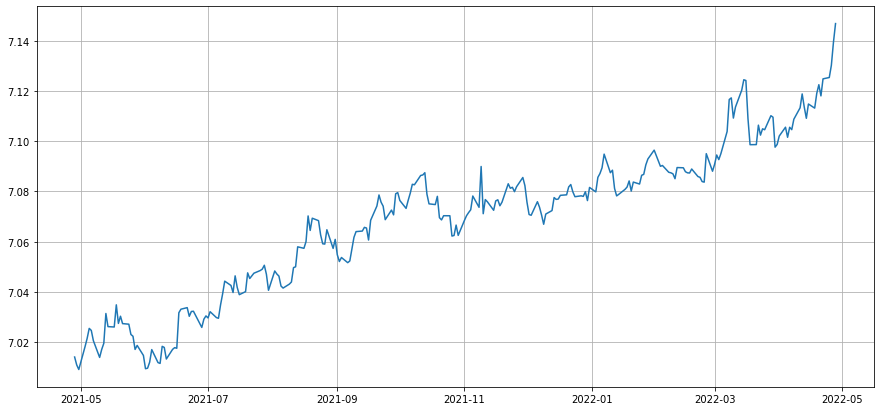

In [41]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # 결측치가 있는 부분만 Series로 출력

# 로그 변환
ts_log = np.log(ts)
plt.grid(True)
plt.plot(ts_log)

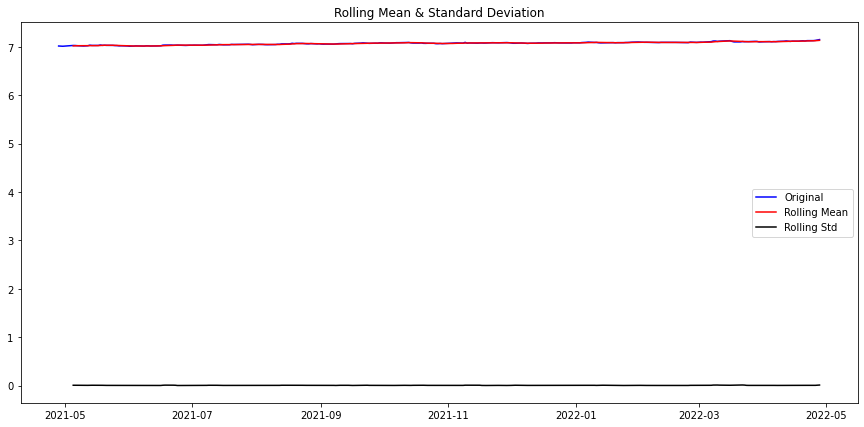

Results of Dickey-Fuller Test:
Test Statistic                  -0.440035
p-value                          0.903197
#Lags Used                       1.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754
Critical Value (5%)             -2.872721
Critical Value (10%)            -2.572728
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.724058e+00
p-value                        3.425072e-09
#Lags Used                     9.000000e+00
Number of Observations Used    2.220000e+02
Critical Value (1%)           -3.460154e+00
Critical Value (5%)           -2.874649e+00
Critical Value (10%)          -2.573757e+00
dtype: float64


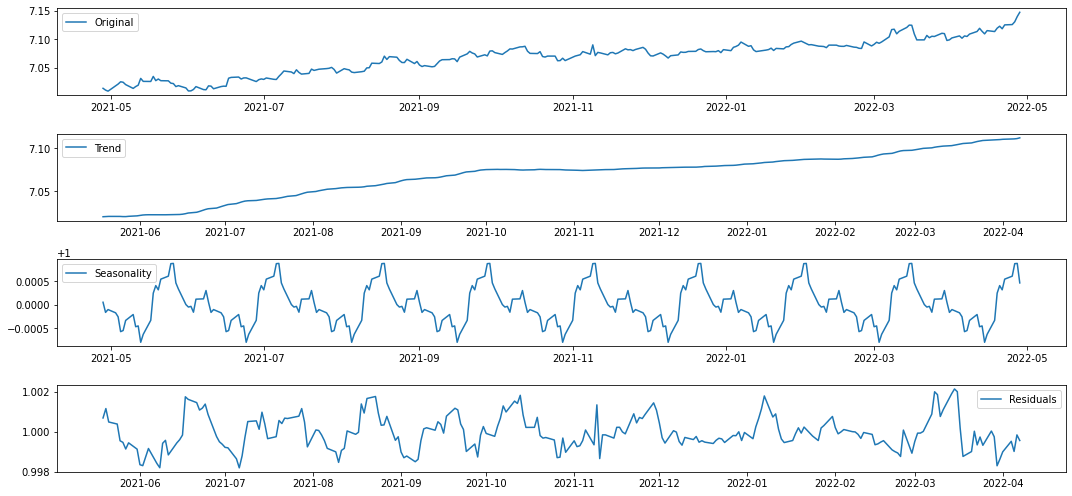

In [42]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=6) #타임 step은 6으로 설정

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

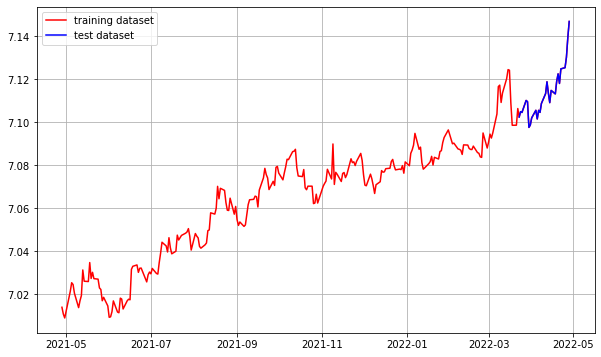

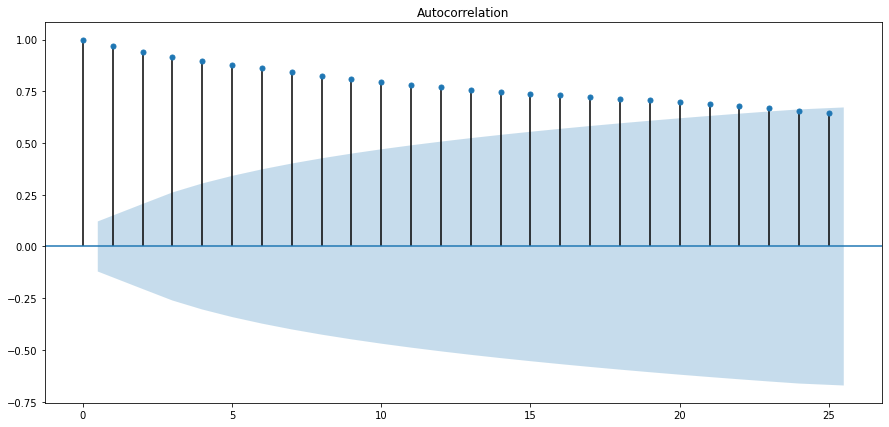

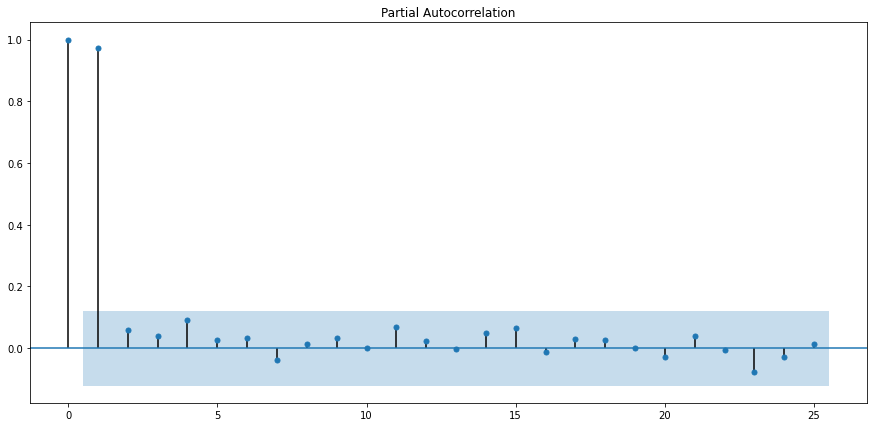

In [43]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)

# train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(ts_log, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.791484e+01
p-value                        2.920544e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.600000e+02
Critical Value (1%)           -3.455754e+00
Critical Value (5%)           -2.872721e+00
Critical Value (10%)          -2.572728e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.492637e+00
p-value                        4.463683e-11
#Lags Used                     1.300000e+01
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


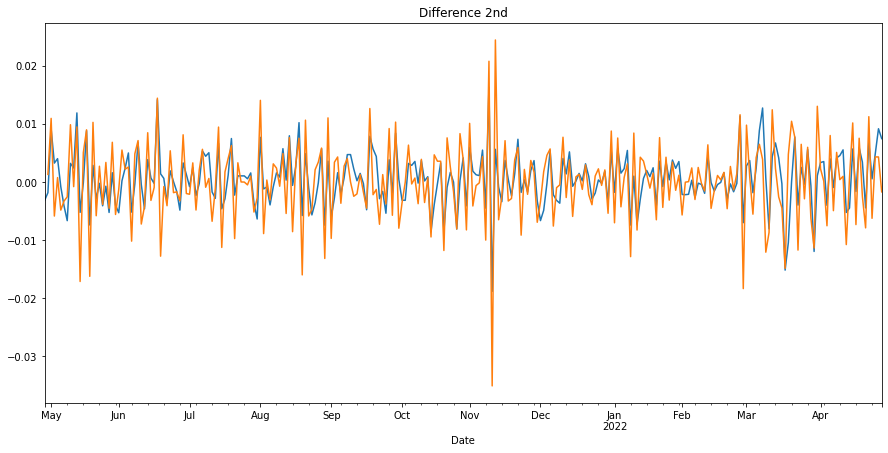

In [44]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  234
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 930.237
Method:                       css-mle   S.D. of innovations              0.005
Date:                Sun, 01 May 2022   AIC                          -1854.474
Time:                        06:28:04   BIC                          -1844.108
Sample:                    04-29-2021   HQIC                         -1850.295
                         - 03-22-2022                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.486      0.137      -0.000       0.001
ar.L1.D.Close    -0.1233      0.065     -1.892      0.059      -0.251       0.004
                                    Root

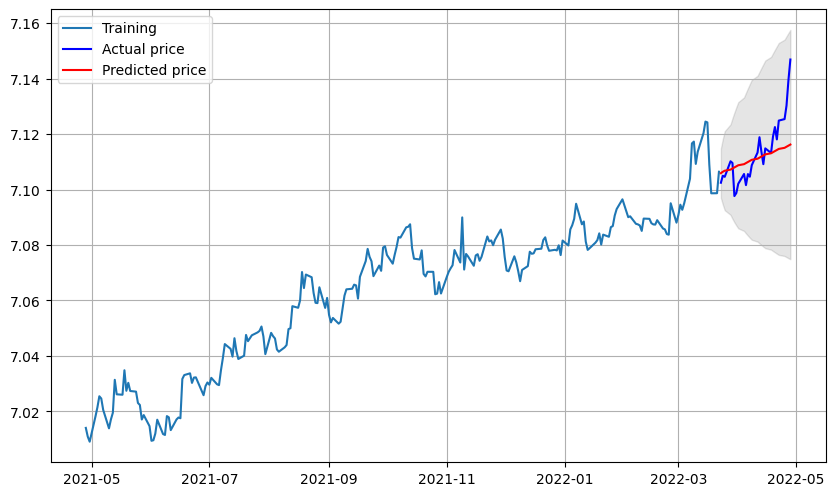

- MSE:  144.493963549301
- MAE:  8.531030048583126
- RMSE:  12.020564194300572
- MAPE: 0.69%


In [45]:
# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0)) 
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# 그래프 구현
plt.figure(figsize=(10,6), dpi=100)
plt.grid(True)
plt.plot(train_data, label='Training')
plt.plot(test_data, c='b', label='Actual price')
plt.plot(fc_series, c='r',label='Predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

#최종 오차 계산 결과
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('- MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('- MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('- RMSE: ', rmse)

mape3 = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('- MAPE: {:.2f}%'.format(mape3*100)) # 여기서 가장 중요하게 쓰인 손실함수 오차값

* 원달러 환율의 경우 상승세를 가리키고 있으며, MAPE 값이 0.69 퍼센트로 1퍼센트 미만의 매우 적은 오차를 보여줬다.

#### 2-4. [원자재:유가] WTI

In [46]:
# 데이터 로드 및 Time Series 생성하기
dataset_filepath = 'WTI.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-04-28,3.18,3.41,3.17,3.35,3.35,3208000
2021-04-29,3.46,3.50,3.32,3.44,3.44,3255400
2021-04-30,3.38,3.41,3.26,3.29,3.29,2385400
2021-05-03,3.35,3.47,3.28,3.46,3.46,2003400
2021-05-04,3.45,3.45,3.27,3.36,3.36,3125900


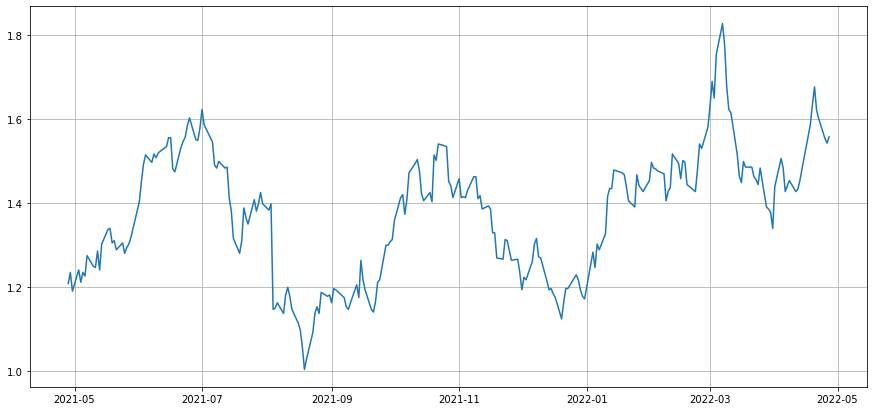

In [47]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # 결측치가 있는 부분만 Series로 출력

# 로그 변환
ts_log = np.log(ts)
plt.grid(True)
plt.plot(ts_log)

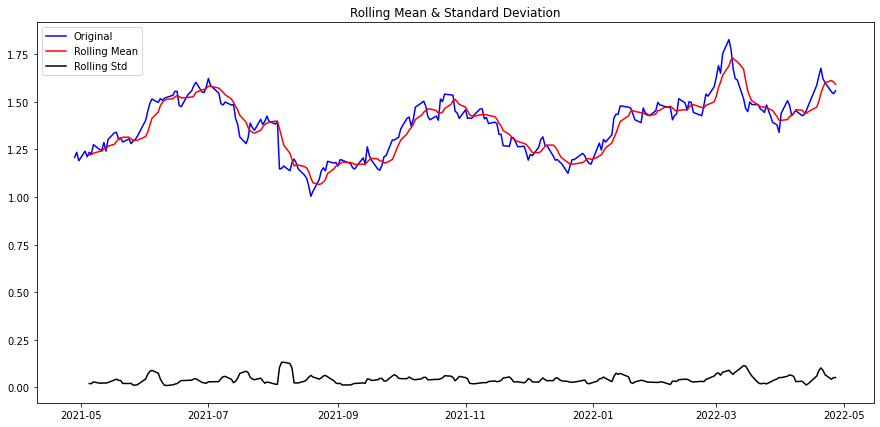

Results of Dickey-Fuller Test:
Test Statistic                  -2.360285
p-value                          0.153261
#Lags Used                       1.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -5.415496
p-value                          0.000003
#Lags Used                       8.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


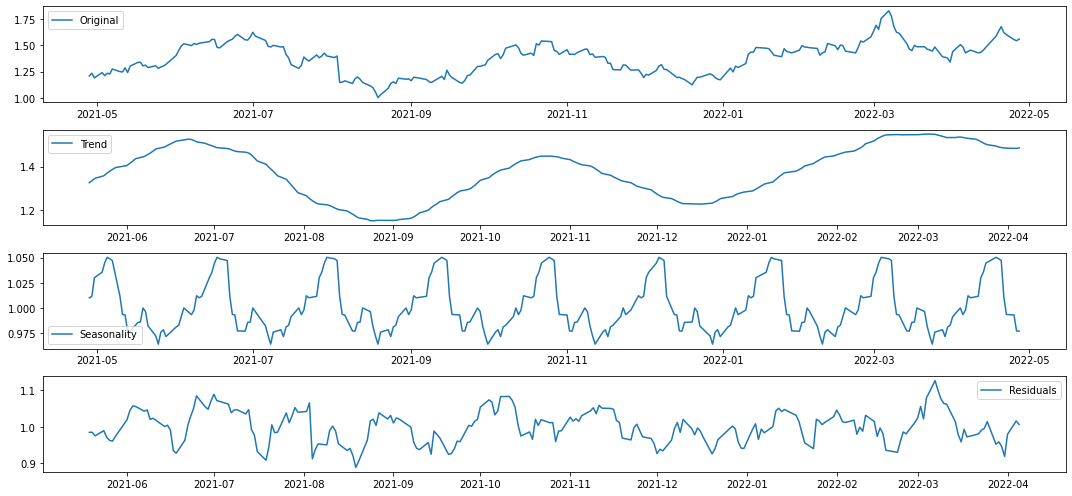

In [48]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=6) #타임 step은 6으로 설정

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

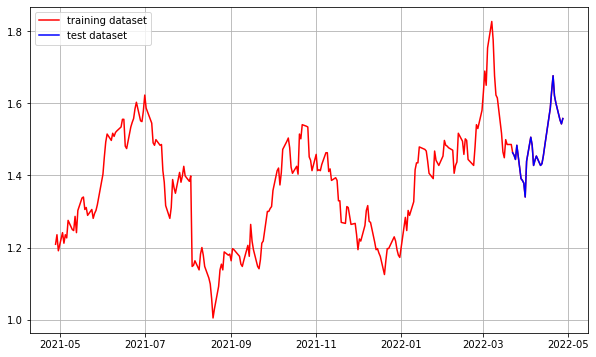

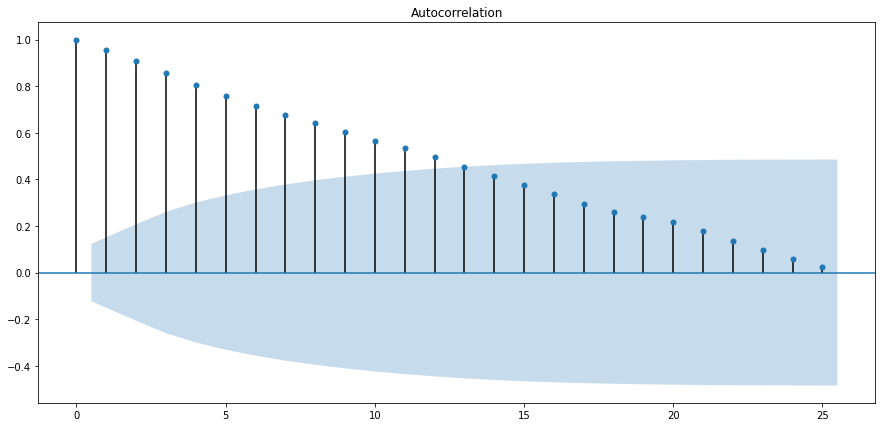

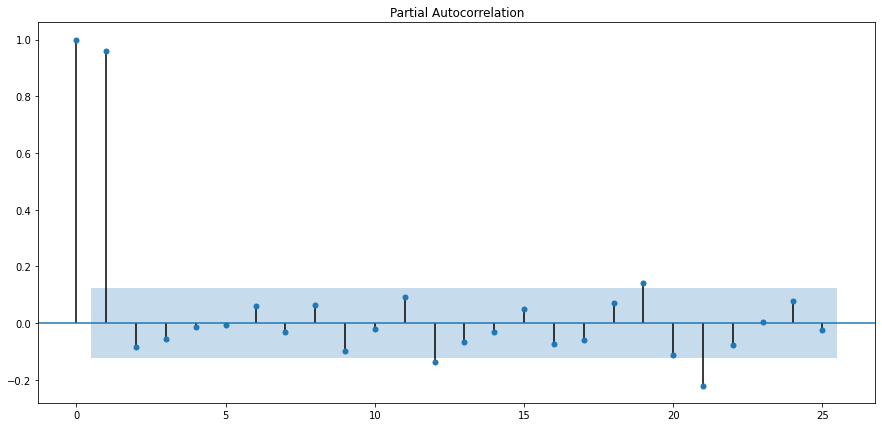

In [49]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)

# train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(ts_log, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.463227e+01
p-value                        3.735630e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.377233e+00
p-value                        2.566604e-13
#Lags Used                     1.100000e+01
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


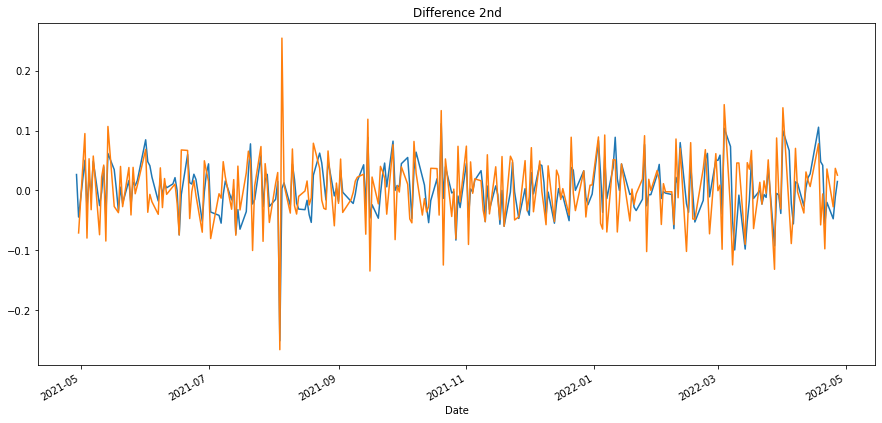

In [50]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 398.239
Method:                       css-mle   S.D. of innovations              0.042
Date:                Sun, 01 May 2022   AIC                           -790.478
Time:                        06:28:40   BIC                           -780.216
Sample:                             1   HQIC                          -786.337
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0012      0.003      0.418      0.676      -0.005       0.007
ar.L1.D.Close     0.0630      0.066      0.950      0.342      -0.067       0.193
                                    Root

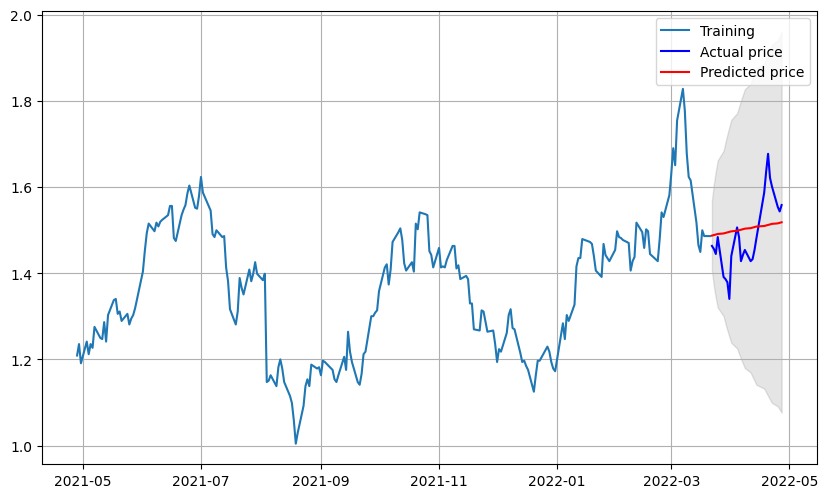

- MSE:  0.12883969102925552
- MAE:  0.3012134097021366
- RMSE:  0.3589424620036692
- MAPE: 6.77%


In [51]:
# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0)) 
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# 그래프 구현
plt.figure(figsize=(10,6), dpi=100)
plt.grid(True)
plt.plot(train_data, label='Training')
plt.plot(test_data, c='b', label='Actual price')
plt.plot(fc_series, c='r',label='Predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

#최종 오차 계산 결과
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('- MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('- MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('- RMSE: ', rmse)

mape4 = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('- MAPE: {:.2f}%'.format(mape4*100)) # 여기서 가장 중요하게 쓰인 손실함수 오차값

* 유가(WTI 기준)의 경우 상승세를 가리키고 있으며, MAPE 값이 6.77이므로 역시 15퍼센트 이하의 오차를 보여줬다.

<br>



### 3. 연관성을 위한 주가 예측
-----
#### 3-1. [미국 주가]S&P 500(SPXL)

In [52]:
# 데이터 로드 및 Time Series 생성하기
dataset_filepath = 'SPXL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-04-28,99.080002,99.930000,98.419998,98.730003,98.600319,6045100
2021-04-29,100.889999,101.120003,98.110001,100.570000,100.437904,6930800
2021-04-30,98.930000,99.589996,98.000000,98.720001,98.590332,6643500
2021-05-03,100.169998,100.470001,98.940002,99.239998,99.109650,5373300
2021-05-04,97.800003,98.169998,94.660004,97.430000,97.302025,9295200


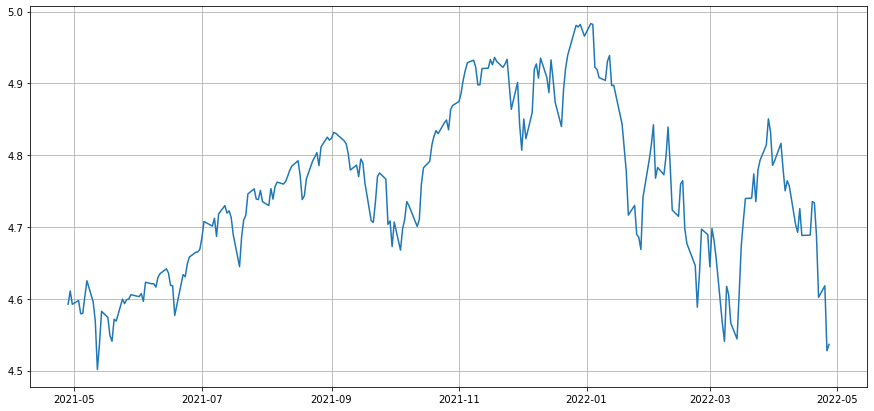

In [53]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # 결측치가 있는 부분만 Series로 출력

# 로그 변환
ts_log = np.log(ts)
plt.grid(True)
plt.plot(ts_log)

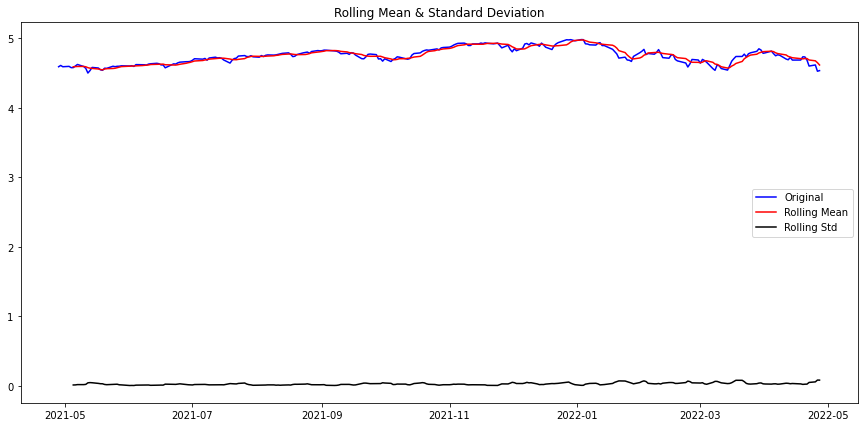

Results of Dickey-Fuller Test:
Test Statistic                  -1.887853
p-value                          0.337797
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -5.149699
p-value                          0.000011
#Lags Used                       1.000000
Number of Observations Used    221.000000
Critical Value (1%)             -3.460291
Critical Value (5%)             -2.874709
Critical Value (10%)            -2.573789
dtype: float64


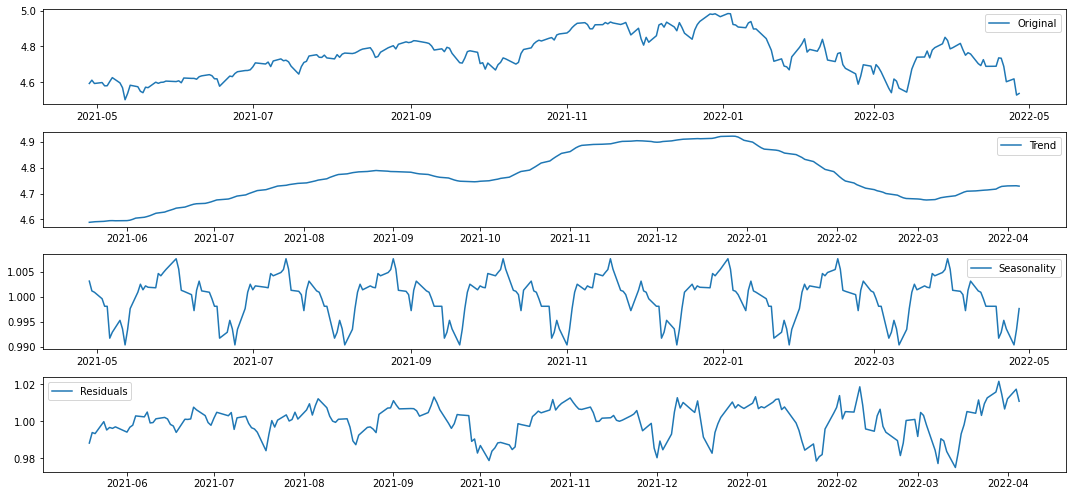

In [54]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=6) #타임 step은 6으로 설정

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

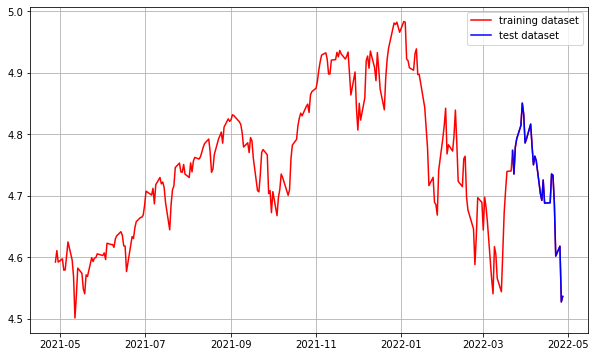

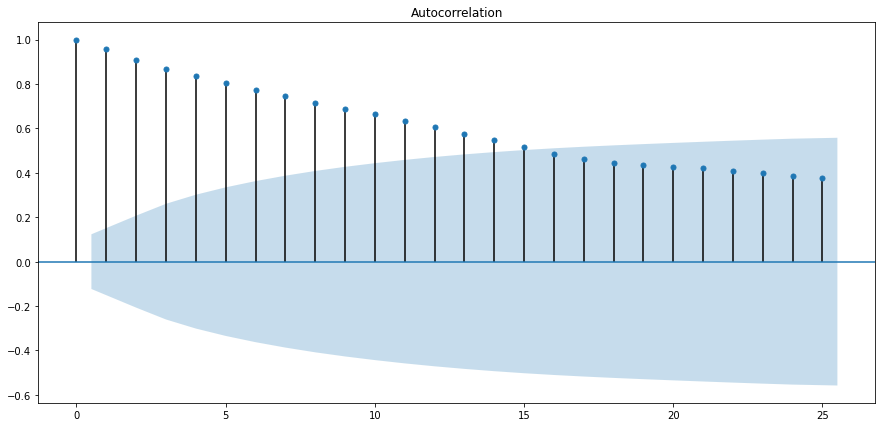

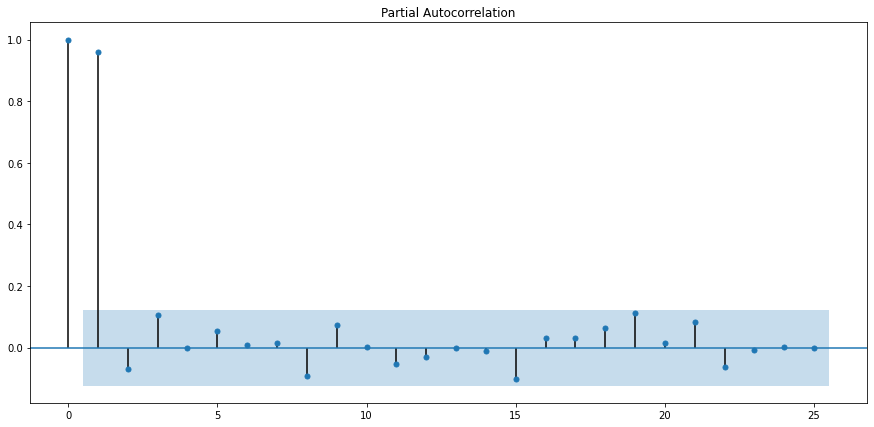

In [55]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)

# train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(ts_log, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.490015e+01
p-value                        1.511330e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.046510e+00
p-value                        1.788587e-12
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


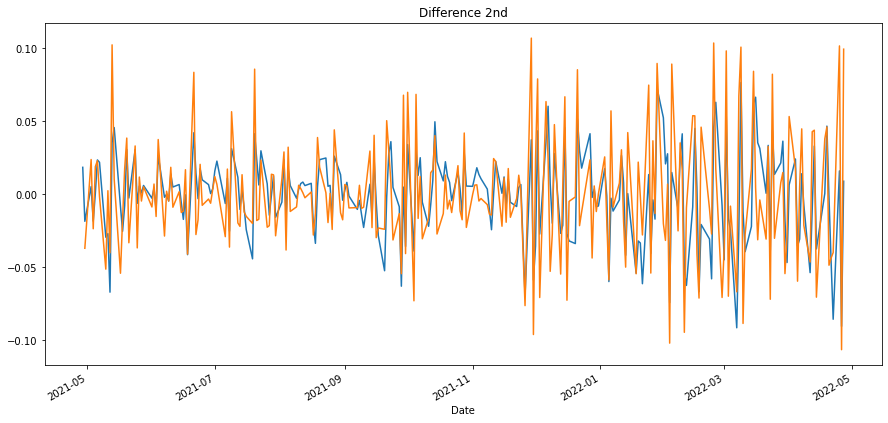

In [56]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  227
Model:                     ARMA(1, 0)   Log Likelihood                 485.503
Method:                       css-mle   S.D. of innovations              0.028
Date:                Sun, 01 May 2022   AIC                           -965.005
Time:                        06:29:15   BIC                           -954.731
Sample:                             0   HQIC                          -960.859
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.7345      0.056     85.067      0.000       4.625       4.844
ar.L1.Close     0.9699      0.015     64.326      0.000       0.940       0.999
                                    Roots       

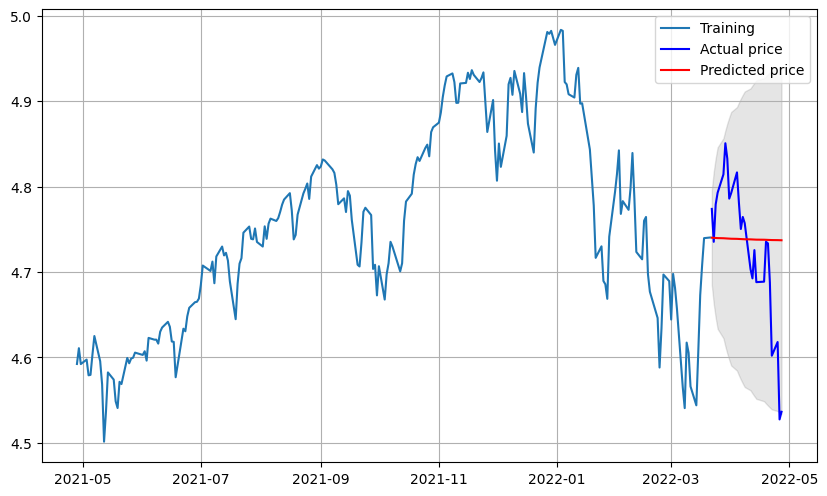

- MSE:  79.20876200813656
- MAE:  6.866029580976341
- RMSE:  8.899930449623556
- MAPE: 6.32%


In [57]:
# Build and Train  Model
model = ARIMA(train_data, order=(1, 0, 0)) 
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# 그래프 구현
plt.figure(figsize=(10,6), dpi=100)
plt.grid(True)
plt.plot(train_data, label='Training')
plt.plot(test_data, c='b', label='Actual price')
plt.plot(fc_series, c='r',label='Predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

#최종 오차 계산 결과
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('- MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('- MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('- RMSE: ', rmse)

mape5 = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('- MAPE: {:.2f}%'.format(mape5*100)) # 여기서 가장 중요하게 쓰인 손실함수 오차값

* 미국 주가를 대표하는 S&P 500의 경우 엄청난 하락세를 보여주는 동시에 예측값도 소폭의 하락세를 보여줬다. 동시에 MAPE 값이 6.32이므로 15퍼센트 이하의 오차를 보여줬다.

#### 3-2. [국내 주가]코스피(^KS11)

In [58]:
# 데이터 로드 및 Time Series 생성하기
dataset_filepath = '^KS11.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-04-28,3217.209961,3219.689941,3176.550049,3181.469971,3181.469971,1412600
2021-04-29,3184.750000,3200.409912,3161.060059,3174.070068,3174.070068,1222400
2021-04-30,3176.429932,3179.429932,3143.379883,3147.860107,3147.860107,1358200
2021-05-03,3149.050049,3174.260010,3120.699951,3127.199951,3127.199951,1040300
2021-05-04,3131.389893,3147.379883,3109.780029,3147.370117,3147.370117,1282900


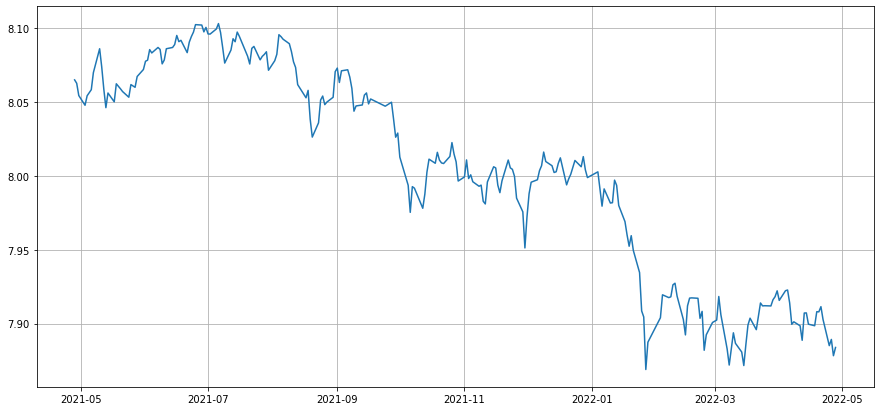

In [59]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # 결측치가 있는 부분만 Series로 출력

# 로그 변환
ts_log = np.log(ts)
plt.grid(True)
plt.plot(ts_log)

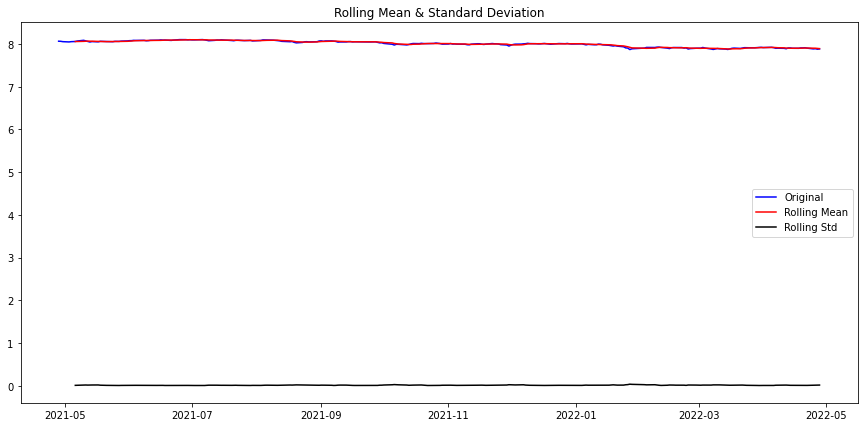

Results of Dickey-Fuller Test:
Test Statistic                  -0.450894
p-value                          0.901248
#Lags Used                       2.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.116152e+00
p-value                        9.084498e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.070000e+02
Critical Value (1%)           -3.462342e+00
Critical Value (5%)           -2.875606e+00
Critical Value (10%)          -2.574267e+00
dtype: float64


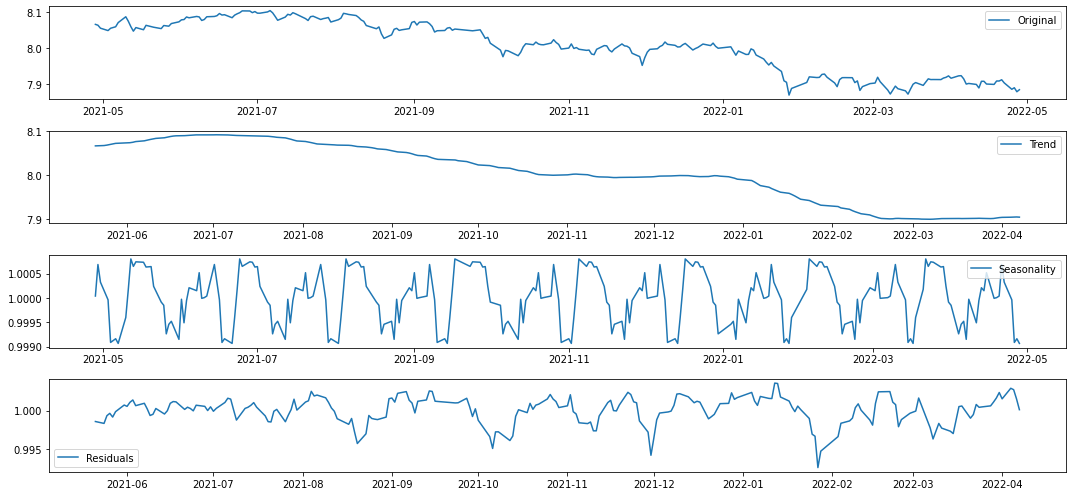

In [60]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=6) #타임 step은 6으로 설정

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

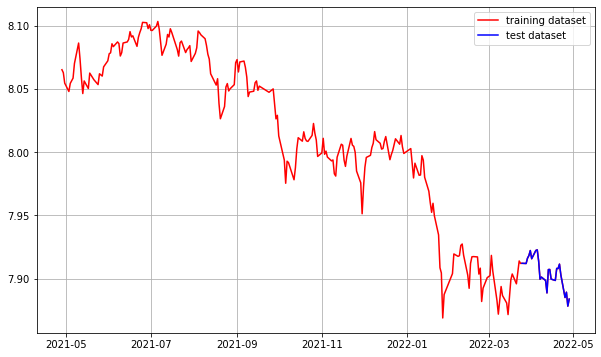

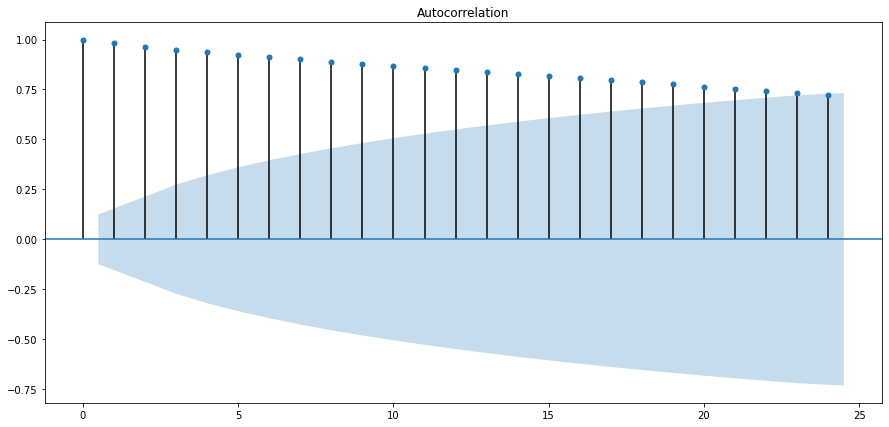

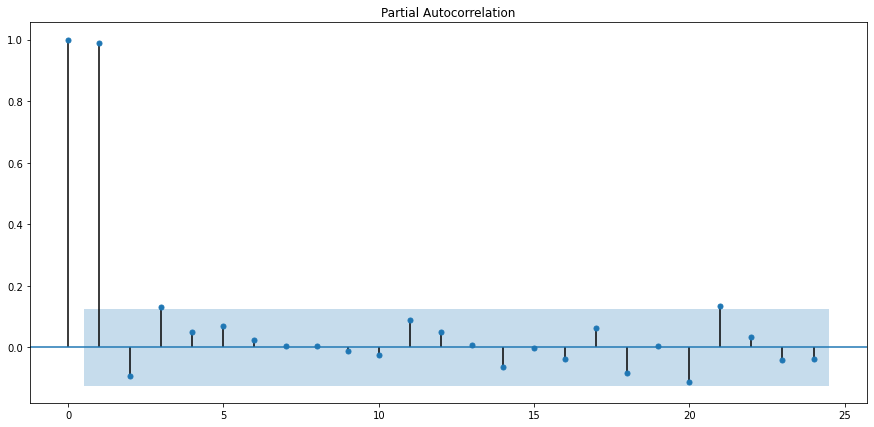

In [61]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)

# train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(ts_log, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 713.476
Method:                       css-mle   S.D. of innovations              0.010
Date:                Sun, 01 May 2022   AIC                          -1420.953
Time:                        06:29:54   BIC                          -1410.758
Sample:                             1   HQIC                         -1416.837
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0007      0.001     -0.971      0.332      -0.002       0.001
ar.L1.D.Close     0.0989      0.067      1.481      0.139      -0.032       0.230
                                    Root

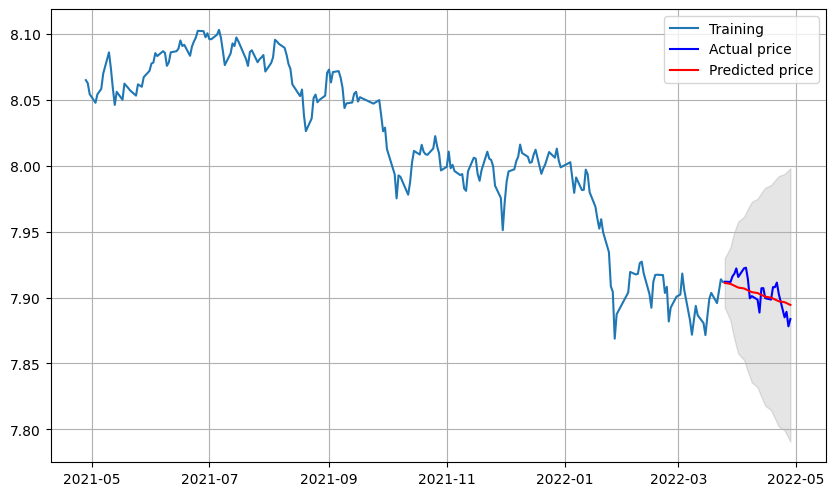

- MSE:  655.3123465027086
- MAE:  22.05802019112929
- RMSE:  25.599069250711217
- MAPE: 0.81%


In [62]:
# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0)) 
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# 그래프 구현
plt.figure(figsize=(10,6), dpi=100)
plt.grid(True)
plt.plot(train_data, label='Training')
plt.plot(test_data, c='b', label='Actual price')
plt.plot(fc_series, c='r',label='Predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

#최종 오차 계산 결과
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('- MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('- MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('- RMSE: ', rmse)

mape6 = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('- MAPE: {:.2f}%'.format(mape6*100)) # 여기서 가장 중요하게 쓰인 손실함수 오차값

* 국내 주가를 대표하는 코스피 역시 앞서 미국 주가와 마찬가지로 하락세를 가리키고 있으며, MAPE 값이 0.81로 1퍼센트 미만의 오차를 보여줬다.

<br>



#### 4. 프로젝트 결론
![001_](https://user-images.githubusercontent.com/100528803/166116944-b28054ff-f26c-4b27-b7d3-e953903a851c.png)

* 각각 [금리 - 물가 - 환율 - 유가] 순서

    1. 금리[인상] > 주가 하락
    2. 물가[상승] > 주가 하락
    3. 환율[상승] > 주가 하락
    4. 원자재[상승] > 주가 상승

주가 하락에 강력한 요인이 되는 금리와 환율이 모두 상승세를 예측하고 있고, 마지막에 주가 상승에 기여되는 원자재가 오히려 상승이 진행되는 중이라는 건 '스태그플레이션(Stagflation)'의 전조임을 확인할 수 있다. 스태그플레이션은 불경기(stagnation)와 인플레이션(inflation)의 합성어로, 경기가 침체되는 상황에서 물가가 상승하는 상태를 의미한다.

![20220501030216](https://user-images.githubusercontent.com/100528803/166117101-75e5b869-b872-45ba-98ff-f094012ec0ed.png)

* 실제로 최근(22년 3월자) 언론에는 스태그플레이션에 대한 예측이 흘러 나오고 있다.

![002_](https://user-images.githubusercontent.com/100528803/166117132-b88ab57b-3377-48b9-9645-90a44b7f91a3.png)

* 각각 미국 주가와 국내 주가는 연일 하락세를 이루고 있으며, 위 스태그플레이션에 대한 확신을 더해준다. 

* 따라서 국내외 거시경제변수와 더불어 국내, 해외 주가를 둘 다 미루어볼 때 '현재 주식에 대한 투자는 위험하며, 장기적으로는 경기 침체가 시작된다는 징조가 비춰지는 이상 한동안은 상승세로 돌아설 때까지 현금 보유를 염두하는 게 좋다'는 점까지 시계열 데이터를 통해 이끌어 낼 수 있었다. 한동안 이어질 침체기가 끝나는 기점부터가 본격적인 매수 시점이며, 이때는 오히려 시장에 공포와 체념이 만연한 상태로 사람들이 아무도 주식 투자를 언급하지 않을 즈음이 기회가 될 것이다. 이 사이클을 더 큰 데이터와 더불어 복합적으로 살펴본다면 능숙한 투자자들이 슬며시 바닥을 예측하고 진입하는 지점을 포착해낼 수 있을지 모른다.

<br>



## ✔️회고 및 결론
---

#### ▶️ 이번 프로젝트에서 어려웠던 점

일단 아이펠 주피터 노트북이 아닌 코랩에서의 작업이었기 때문에 몇가지 업데이트와 버전, 모듈 문제가 있어서 그 과정을 찾기까지가 까다로웠다. 하지만 하나씩 과정을 찾아가면서 해결해나가면서 작은 보람을 느끼기도 했다. 중간에 프로젝트를 보다보면 같은 코드더라도 차분(d)값이 1이냐 0이냐에 따라서 ARMA, ARIMA로 서로 다르게 나오는 것을 확인할 수 있는데 차분의 여부로 두 모델의 여부가 달라진다는 걸 재차 확인할 수 있는 기회였다.

<br>

#### ▶️ 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

야후 파이낸스(Yahoo Finance)에서 각각의 데이터들을 받아서 하나씩 뽑아가는 과정이 흥미로웠고, 이왕 뽑아낼거면 좀 더 장기적인 투자의 지표가 되는 요소들을 추출해내는 점에 초점을 맞췄다. 아무리 주식 투자라는 게 불확실하고 실제 데이터로 집계하기도 힘들다는 걸 알지만, 거시적인 관점에서 볼 때 큰 변수들은 주식들의 장기적 지표로서 그 가치가 있기 때문이다. 개인적으로 이 데이터들을 이론적으로 알면서 실제로 구현하기 힘들어 답답했었는데, 이번 기회에 머릿속에만 있던 이론을 실제 데이터로 정립해볼 수 있다는 것만으로도 만족스러웠다.

<br>

#### ▶️ 루브릭 평가 지표를 맞추기 위해 시도한 것들

이번 프로젝트에서 루브릭의 기준은 아래와 같았다.
1. 시계열의 안정성이 충분히 확인되었는가?
2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?
3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?

<br>

In [65]:
print(f"- 1. '삼성전자'의  MAPE 예측 정확도 수치는 [{mape0: .2f}% ]입니다.")
print()
print(f"- 2-1. '금리(미국 10년 채권)'의  MAPE 예측 정확도 수치는 [{mape1: .2f}% ]입니다.")
print(f"- 2-2. '물가(Tiger 200 Industrials)'의  MAPE 예측 정확도 수치는 [{mape2: .2f}% ]입니다.")
print(f"- 2-3. '환율(원달러 환율)'의  MAPE 예측 정확도 수치는 [{mape3: .2f}% ]입니다.")
print(f"- 2-4. '원자재(유가)'의  MAPE 예측 정확도 수치는 [{mape4: .2f}% ]입니다.")
print()
print(f"- 3-1. '미국 주가(S&P 500)'의  MAPE 예측 정확도 수치는 [{mape5: .2f}% ]입니다.")
print(f"- 3-2. '국내 주가(코스피)'의  MAPE 예측 정확도 수치는 [{mape6: .2f}% ]입니다.")

- 1. '삼성전자'의  MAPE 예측 정확도 수치는 [ 0.01% ]입니다.

- 2-1. '금리(미국 10년 채권)'의  MAPE 예측 정확도 수치는 [ 0.11% ]입니다.
- 2-2. '물가(Tiger 200 Industrials)'의  MAPE 예측 정확도 수치는 [ 0.16% ]입니다.
- 2-3. '환율(원달러 환율)'의  MAPE 예측 정확도 수치는 [ 0.01% ]입니다.
- 2-4. '원자재(유가)'의  MAPE 예측 정확도 수치는 [ 0.07% ]입니다.

- 3-1. '미국 주가(S&P 500)'의  MAPE 예측 정확도 수치는 [ 0.06% ]입니다.
- 3-2. '국내 주가(코스피)'의  MAPE 예측 정확도 수치는 [ 0.01% ]입니다.


한번 모델의 흐름을 구축해둔 뒤에는 그대로 돌려서 도출시키기만 해도 정확한 시계열 데이터 예측을 뽑아낼 수 있어서 놀라웠다. 여기 쓰인 삼성전자, 거시경제변수(금리, 물가, 유가, 환율)와 국내 주가, 해외 주가 포함한 총 7개의 데이터 모두 오차율이 루브릭 평가 기준인 15퍼센트 아래를 하회했기에 루브릭의 기준은 만족한 것으로 판단된다.

<br>

#### ▶️ 자기 다짐

실제로 투자를 위해 주식을 예측한다는 건 실제로 변수가 많기 때문에 부질없다고 생각한다. 그 생각은 이 결과를 도출한 후에도 변함없지만 주가를 예측할 수 없다면 큰 거시적 경제의 변화를 수많은 데이터로 취합해 예측한 뒤, 이에 맞춰서 경기민감주, 둔감주, 테마주 등의 주식을 카테고리별로 조사한 뒤 매수하는 쪽이 더 타당하다고 판단했고 그 판단에 설득력을 더할 수 있는 시간이었다.

그렇다고 과연 이걸 정확히 예측해서 벌 수 있을까? 를 묻는다면 그건 결국 트레이더로서 개인 재량이므로 노코멘트로 끝내고 싶다........

<br>

## ✔️Reference(참고자료)
---
* https://github.com/yeon42/AIFFEL_Exploration/blob/main/%5BE-11%5DStock_Prediction/%5BE-11%5DARIMA.ipynb
* https://assaeunji.github.io/data%20analysis/2021-09-25-arimastock/
* https://predictor-ver1.tistory.com/3
* https://sirano-burnstein.tistory.com/44
* https://louie-min.tistory.com/47
* https://papasean.tistory.com/38
* https://www.joongang.co.kr/article/25055303#home